In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os

# Preprocess

In [3]:
human_labelled_path = "Segmentation_new/contoured_lungs/"
alg_labelled_path = "Segmentation_new/segmented_lungs"
file_names = os.listdir(human_labelled_path)

### reading and resizing

In [4]:
human_labelled_images = []
alg_labelled_images = []

for file_name in file_names:
    human_file_path = os.path.join(human_labelled_path, file_name)
    alg_file_path = os.path.join(alg_labelled_path, file_name)

    human_img = cv.imread(human_file_path) 

    # resizing the algorithm labelled image to match the resolution of human labelled
    alg_img = cv.resize(cv.imread(alg_file_path), (human_img.shape[1], human_img.shape[0]))

    if human_img is not None and alg_img is not None:
        human_labelled_images.append(human_img)
        alg_labelled_images.append(alg_img)
    else:
        print(f"Error reading images: {file_name}")

human_labelled_images = np.array(human_labelled_images)
alg_labelled_images = np.array(alg_labelled_images)

human_labelled_images.shape, alg_labelled_images.shape

((43, 1194, 1920, 3), (43, 1194, 1920, 3))

### cropping out common redundant parts

In [5]:
#cropping edges
human_labelled_images = human_labelled_images[:, 180:1120, :1700,:]
alg_labelled_images = alg_labelled_images[:, 180:1120, :1700,:]

human_labelled_images[:, 800:900, 200:250, :] = 0
alg_labelled_images[:, 800:900, 200:250, :] = 0

human_labelled_images.shape, alg_labelled_images.shape

((43, 940, 1700, 3), (43, 940, 1700, 3))

### viewing a random sample

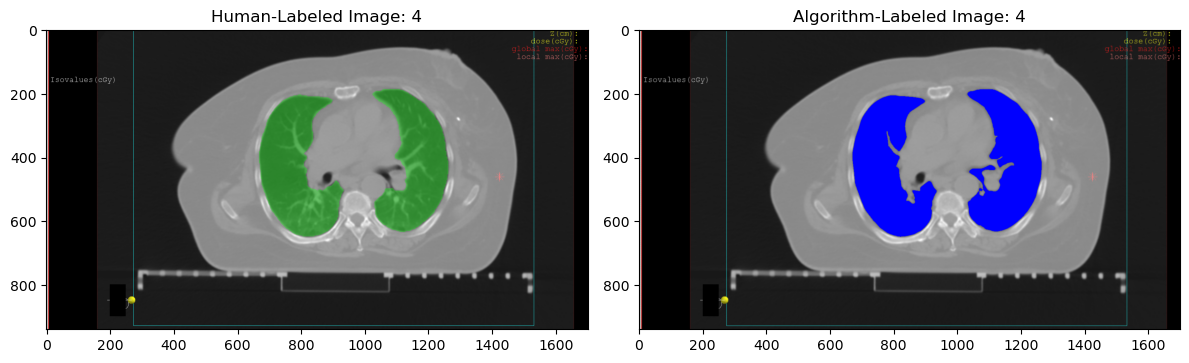

In [6]:
index = np.random.randint(17)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cv.cvtColor(human_labelled_images[34], cv.COLOR_BGR2RGB)) 
axes[0].set_title(f"Human-Labeled Image: {index}")

axes[1].imshow(cv.cvtColor(alg_labelled_images[34], cv.COLOR_BGR2RGB))
axes[1].set_title(f"Algorithm-Labeled Image: {index}")

plt.tight_layout()
plt.show()

# Calculate the IoU 

In [7]:
def IoU (human_img, alg_img, label): 
    human_img_hsv = cv.cvtColor(human_img, cv.COLOR_BGR2HSV)
    lower_green = (40, 40, 40) 
    upper_green = (80, 255, 255)
    human_mask = cv.inRange(human_img_hsv, lower_green, upper_green)

    alg_img_hsv = cv.cvtColor(alg_img, cv.COLOR_BGR2HSV)
    lower_blue = (100,50,50)
    upper_blue = (140,255,255)
    alg_mask = cv.inRange(alg_img_hsv,lower_blue,upper_blue)

    intersection_size = np.count_nonzero(np.bitwise_and(human_mask, alg_mask))
    union_size = np.count_nonzero(np.bitwise_or(human_mask, alg_mask))
    iou = intersection_size/union_size

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Image: {label}, IoU: {iou*100:.2f}%")

    axes[0].imshow(human_mask, cmap='gray')
    axes[0].set_title("Human-Labeled Image")
    
    axes[1].imshow(alg_mask, cmap='gray')
    axes[1].set_title("Algorithm-Labeled Image")
    
    plt.tight_layout()
    plt.show()

    return iou

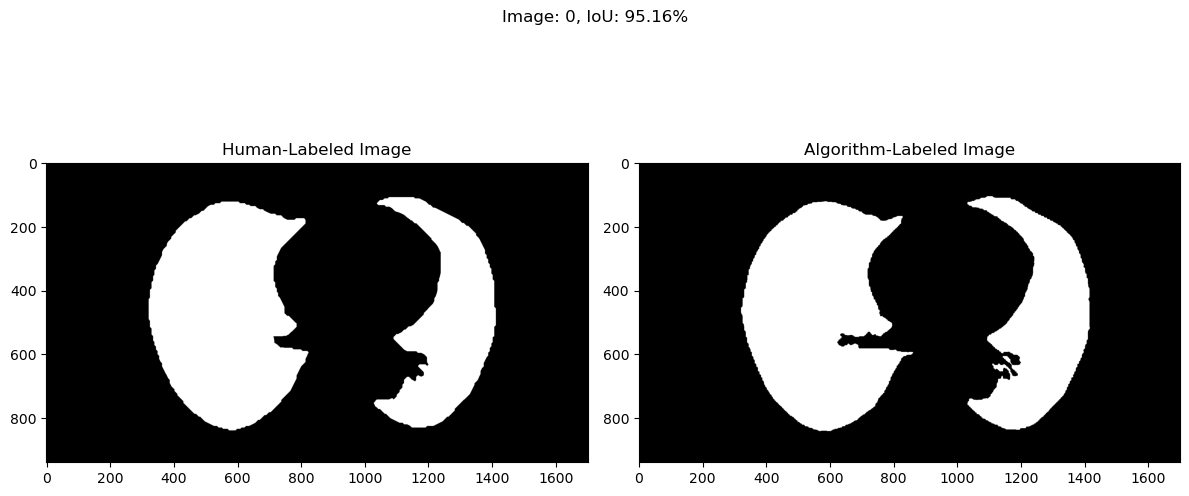

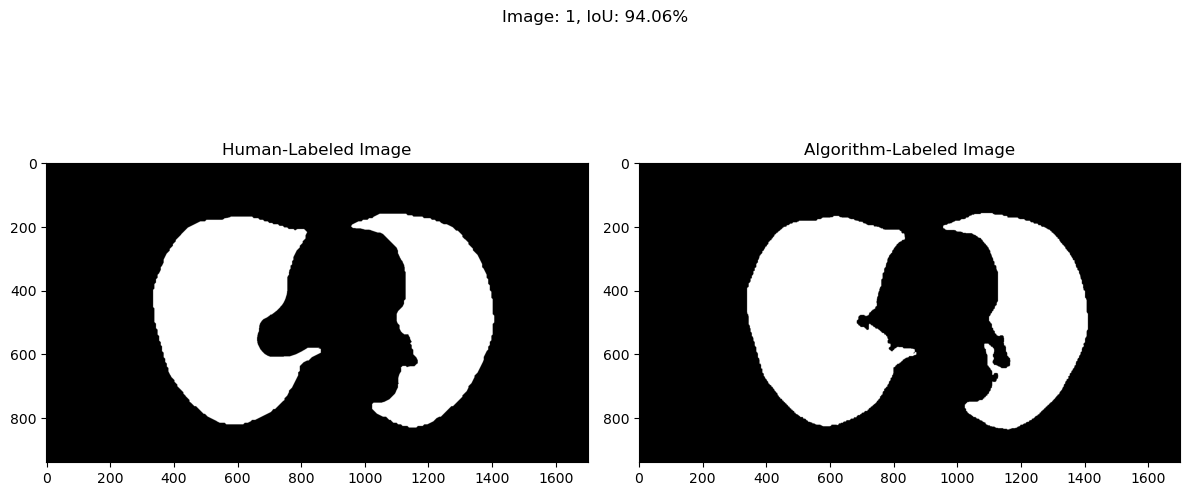

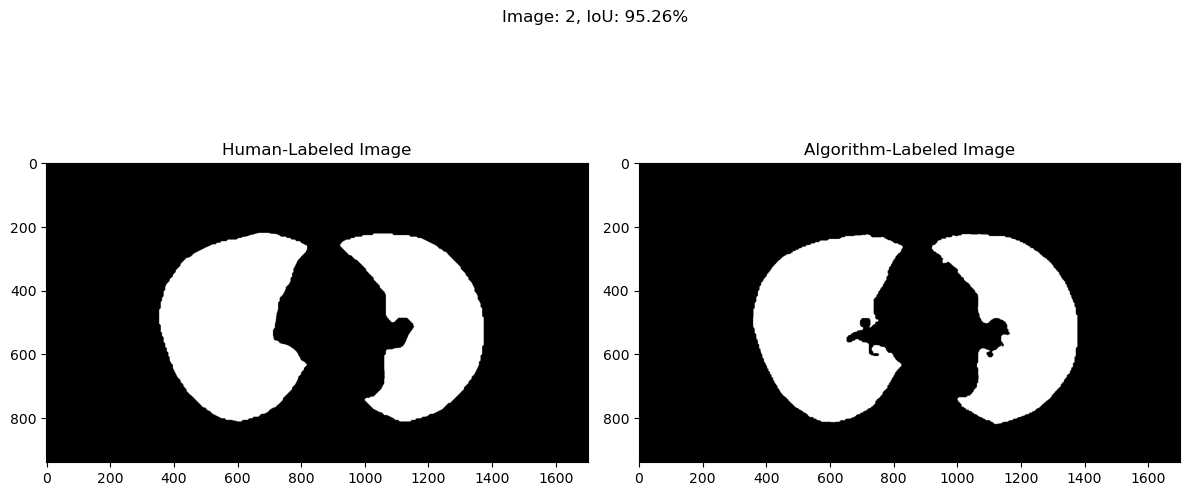

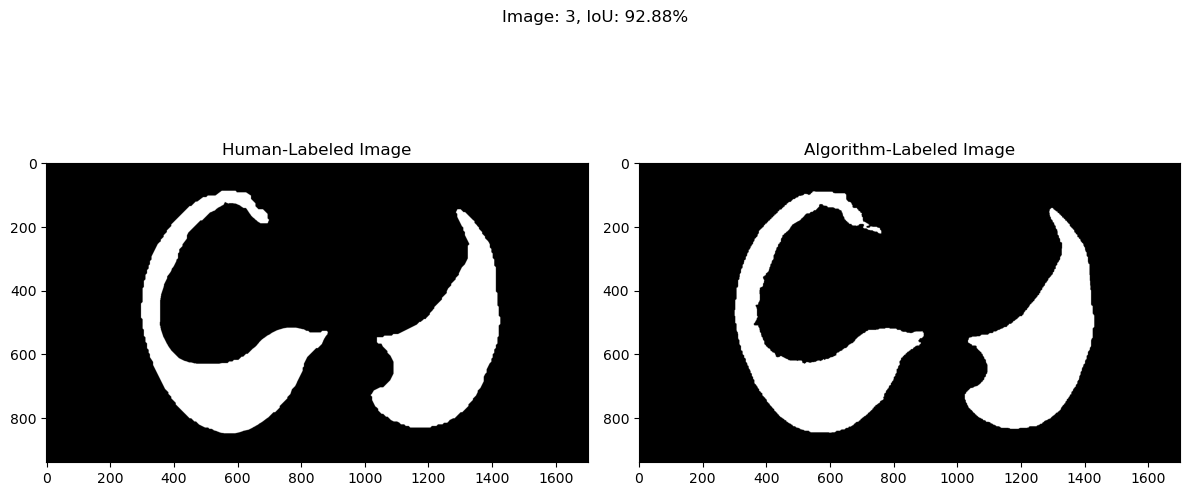

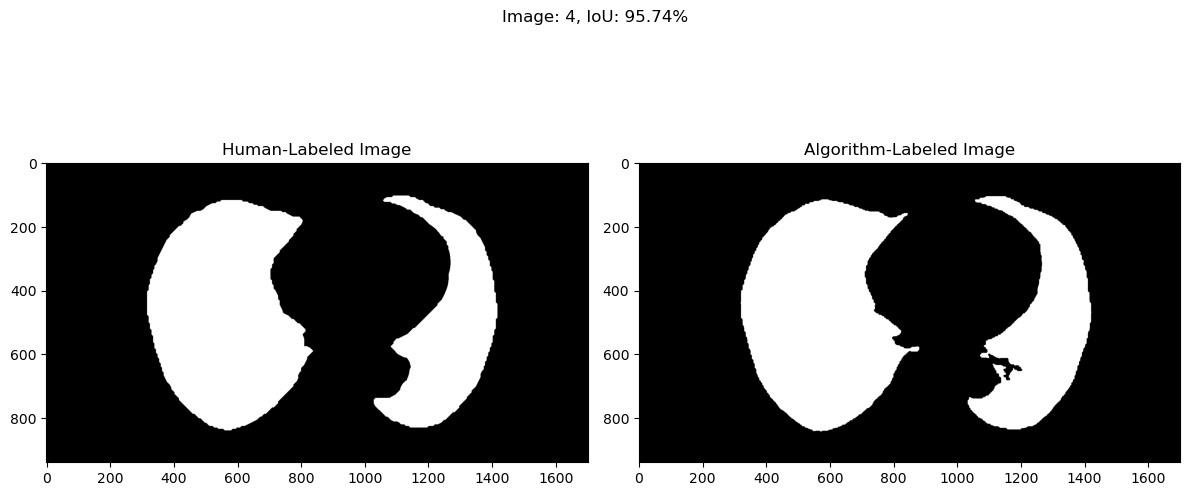

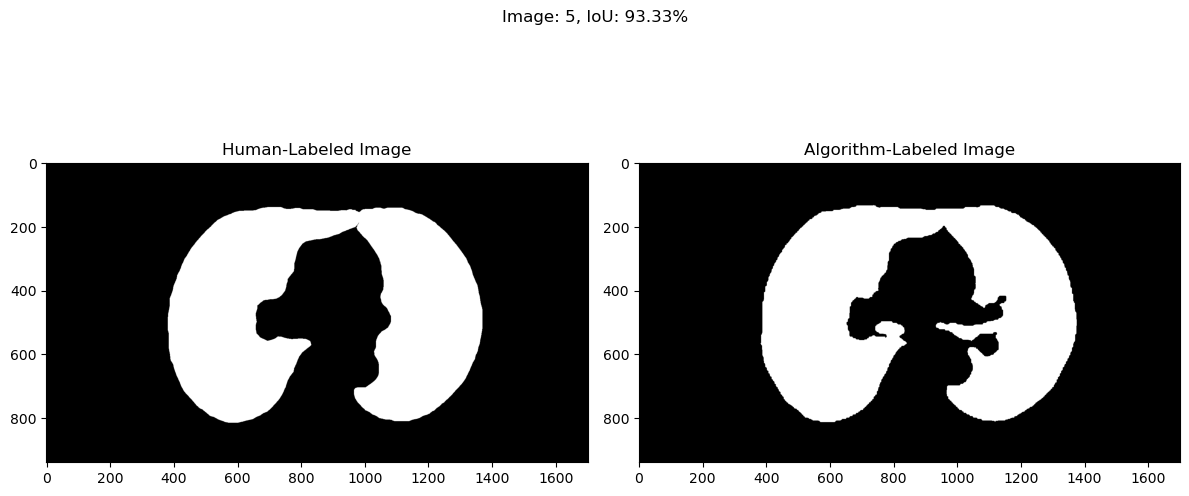

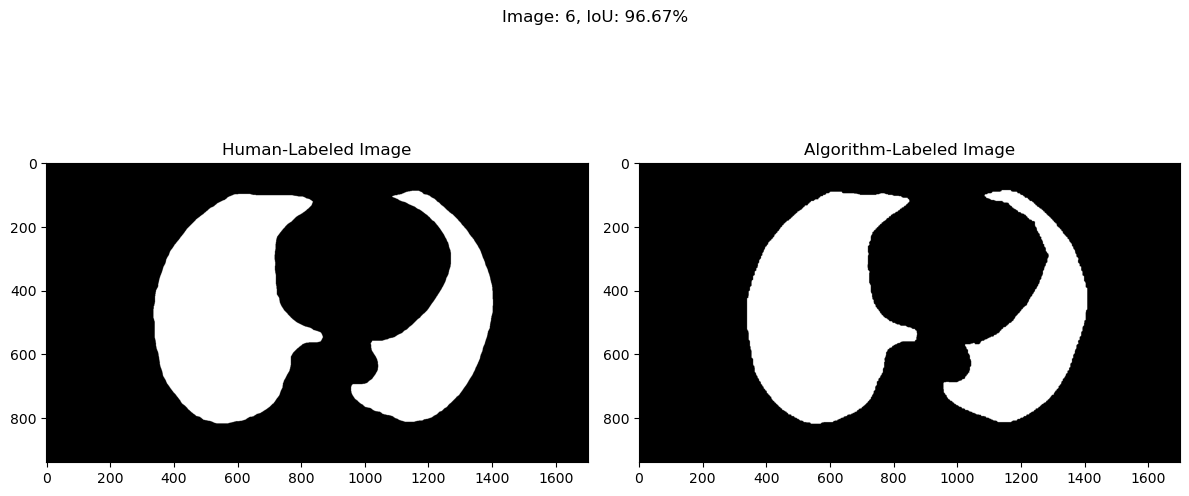

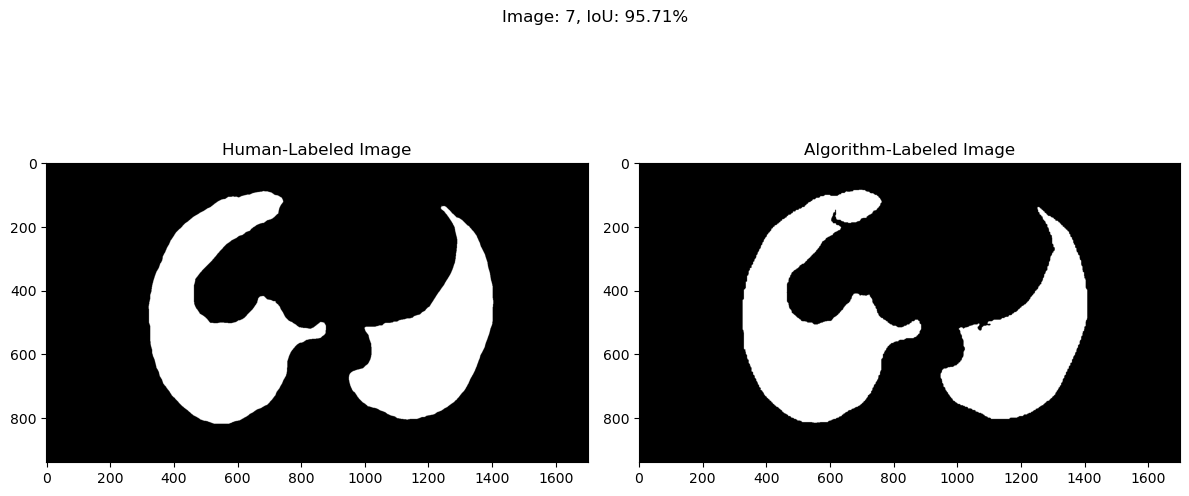

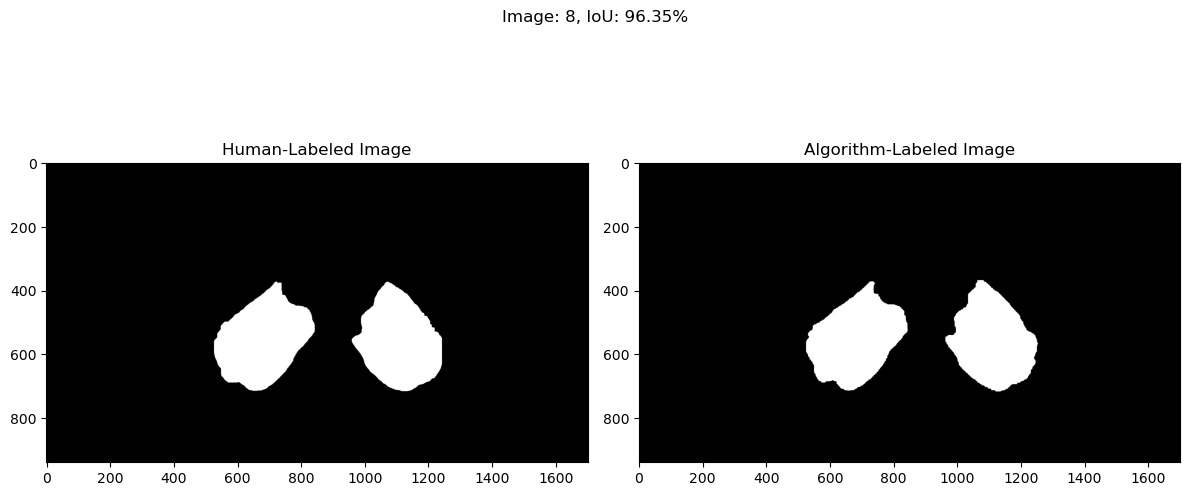

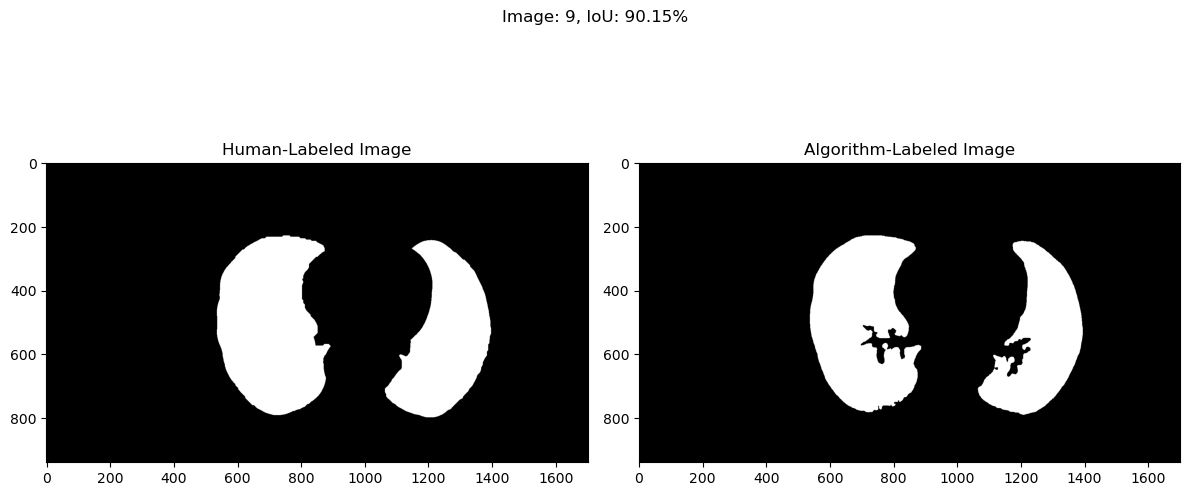

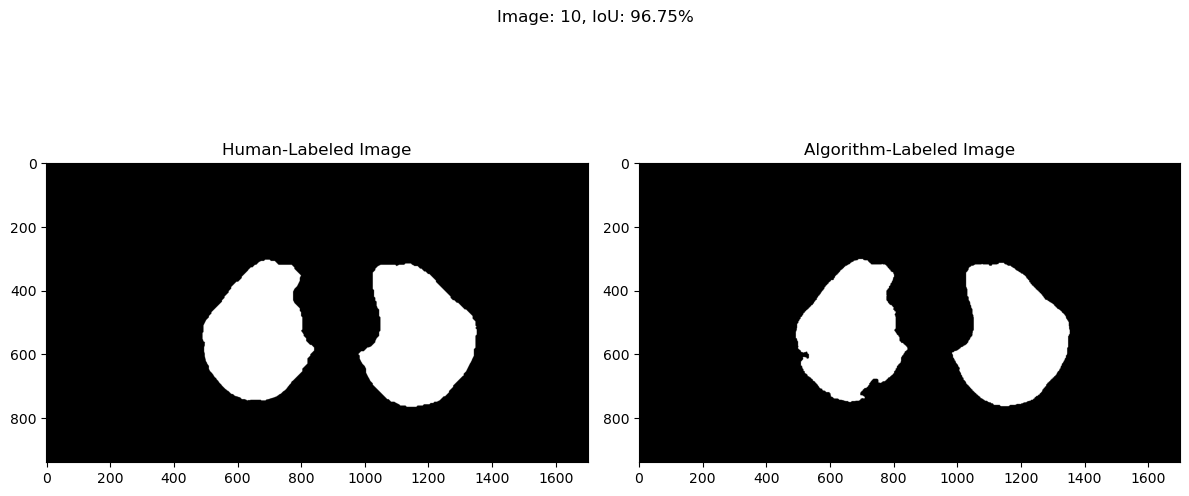

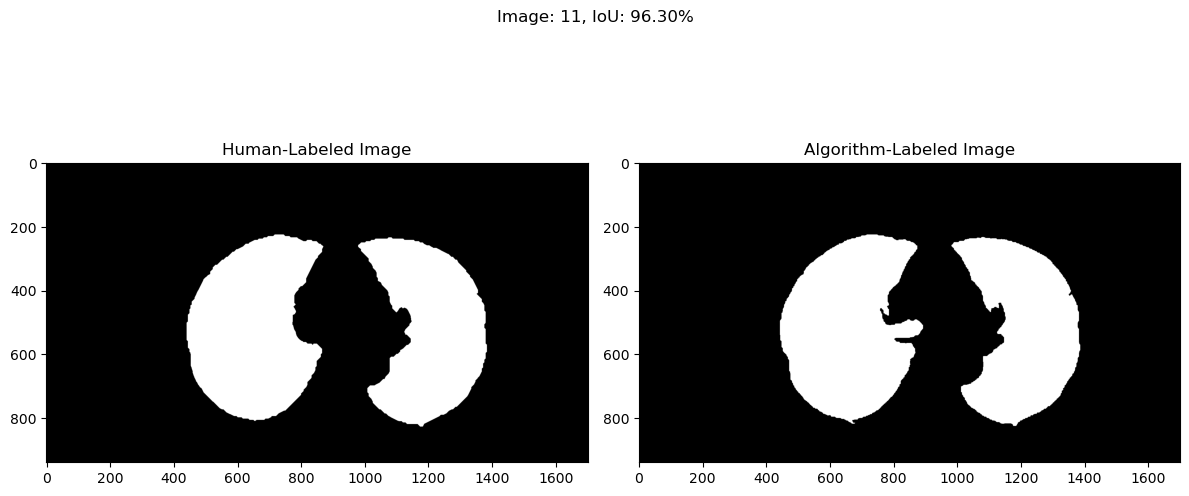

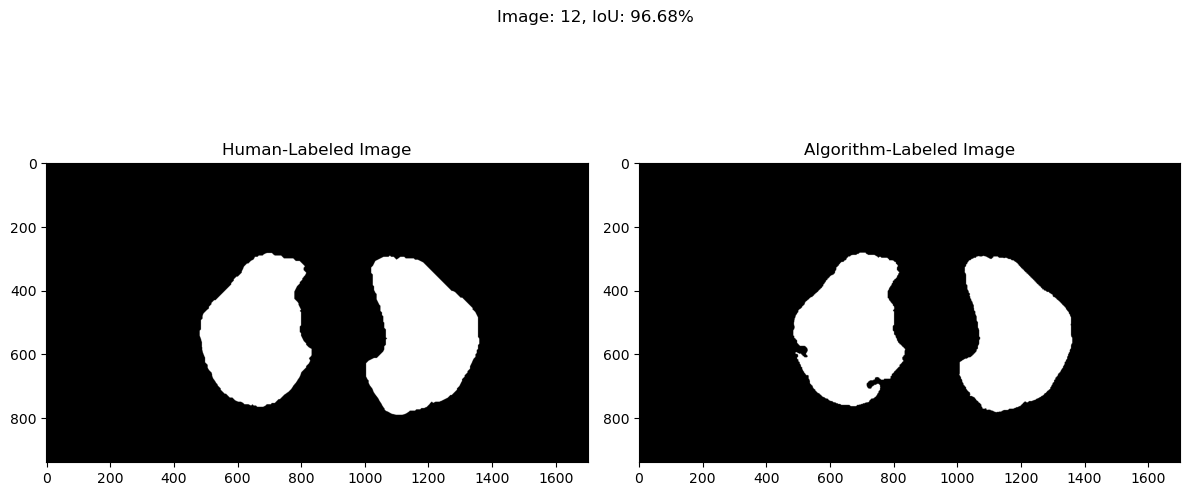

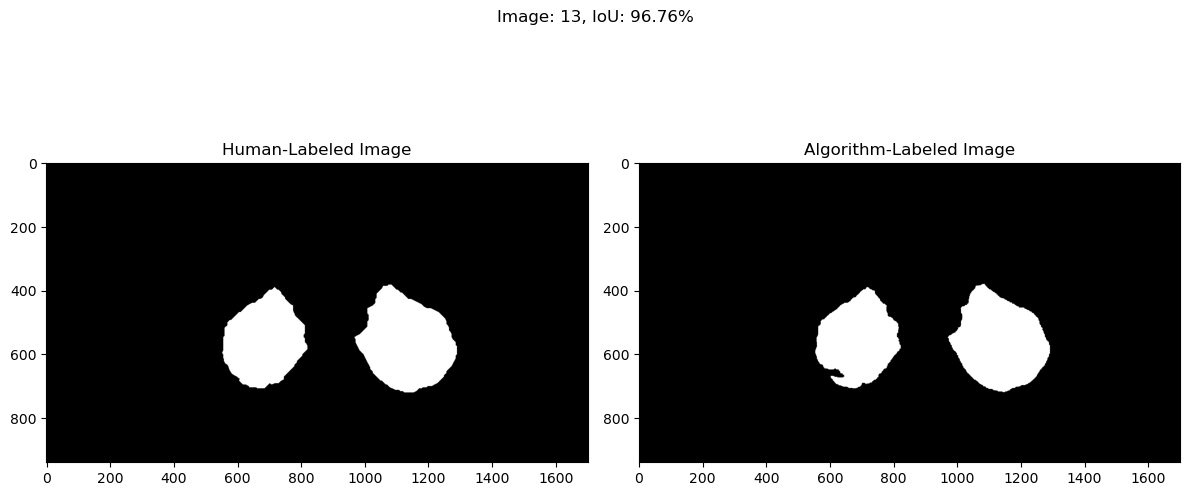

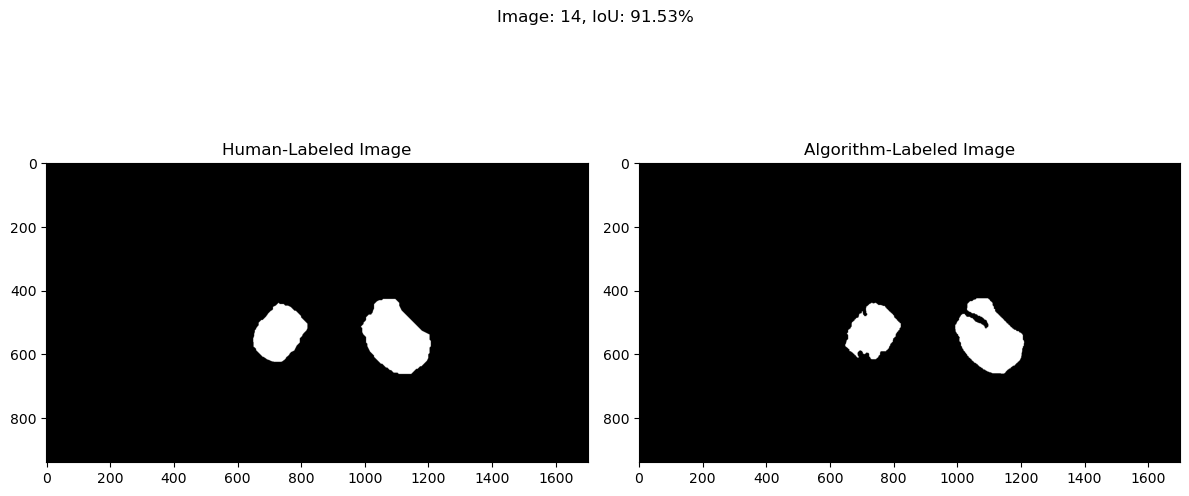

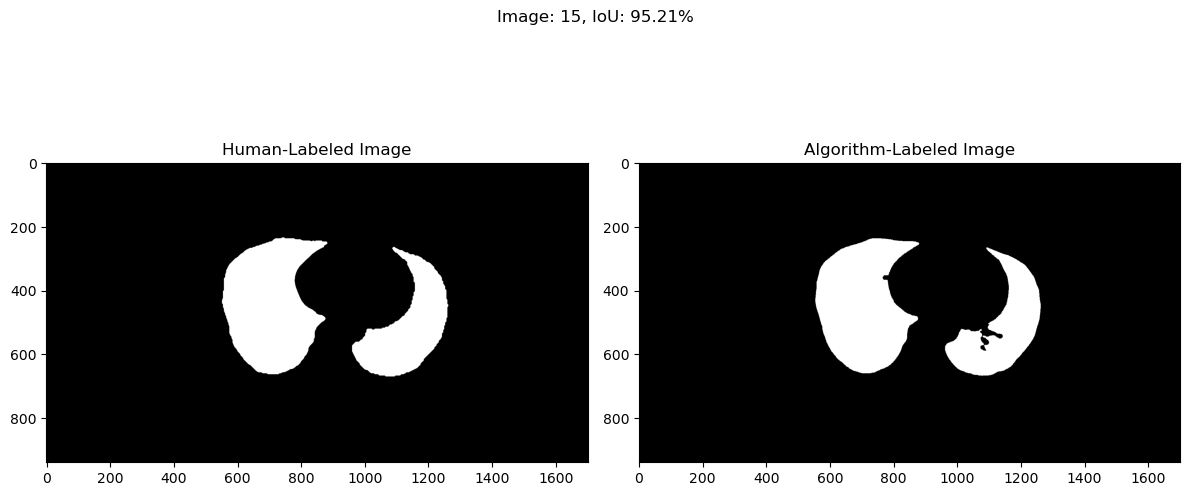

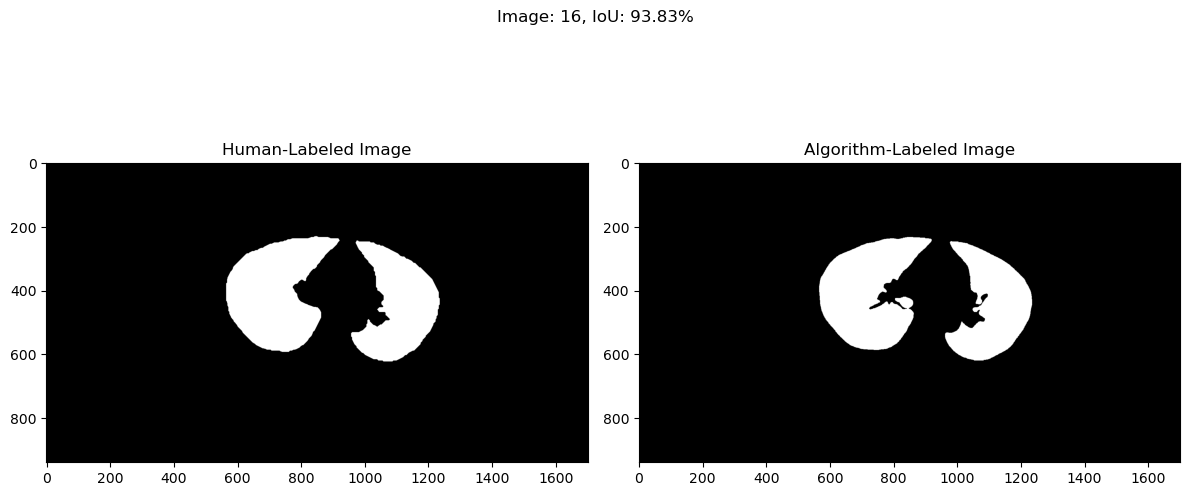

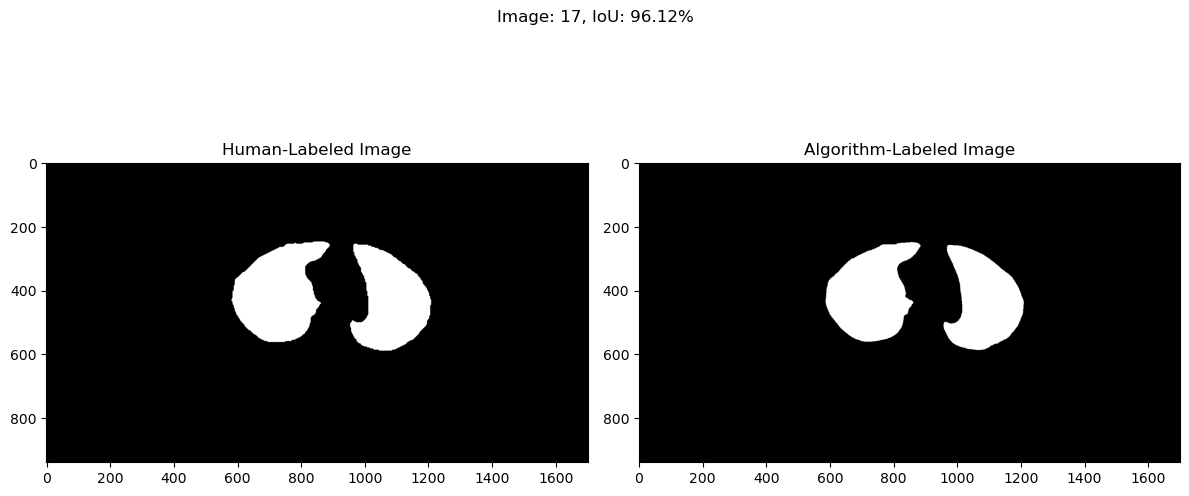

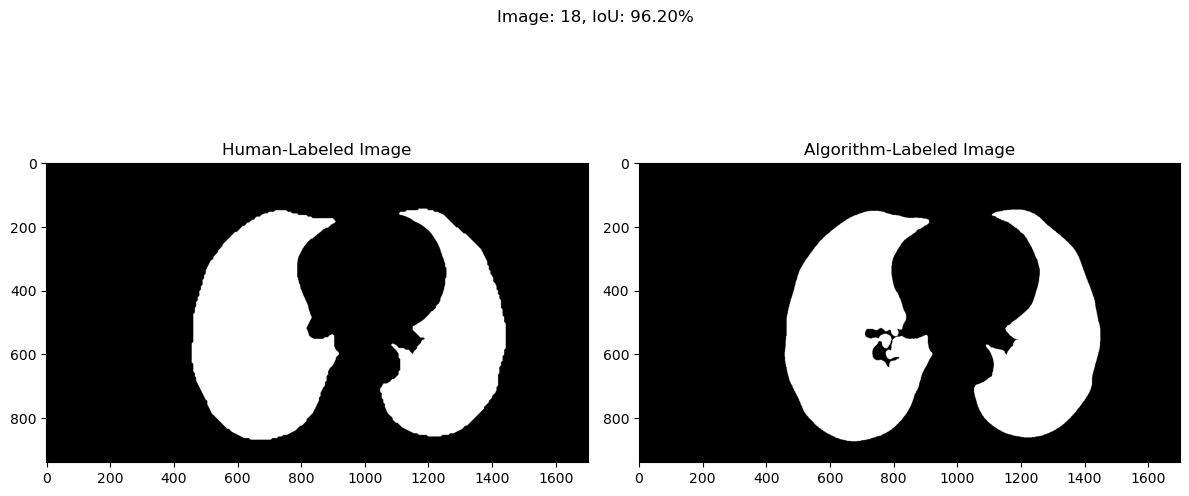

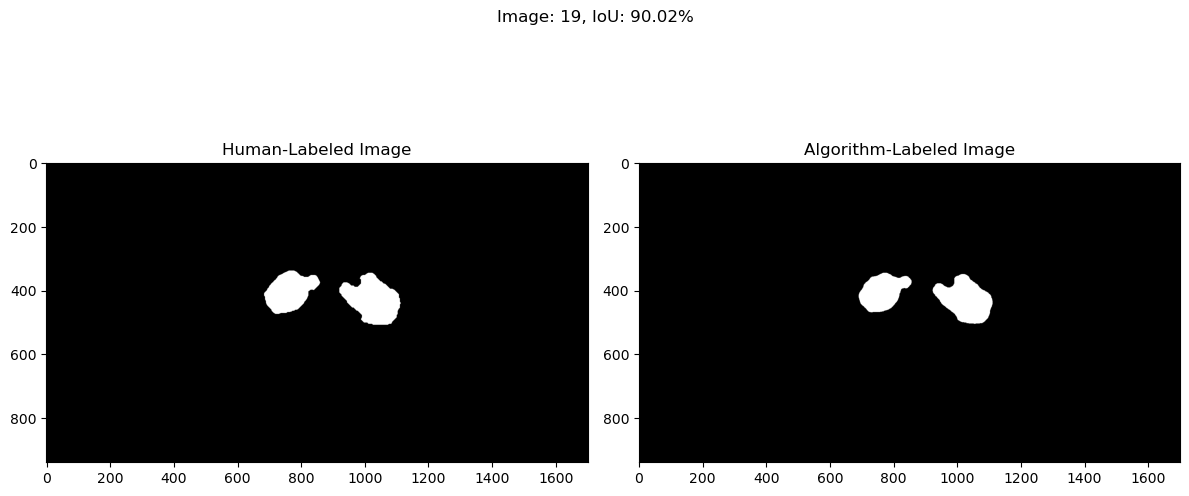

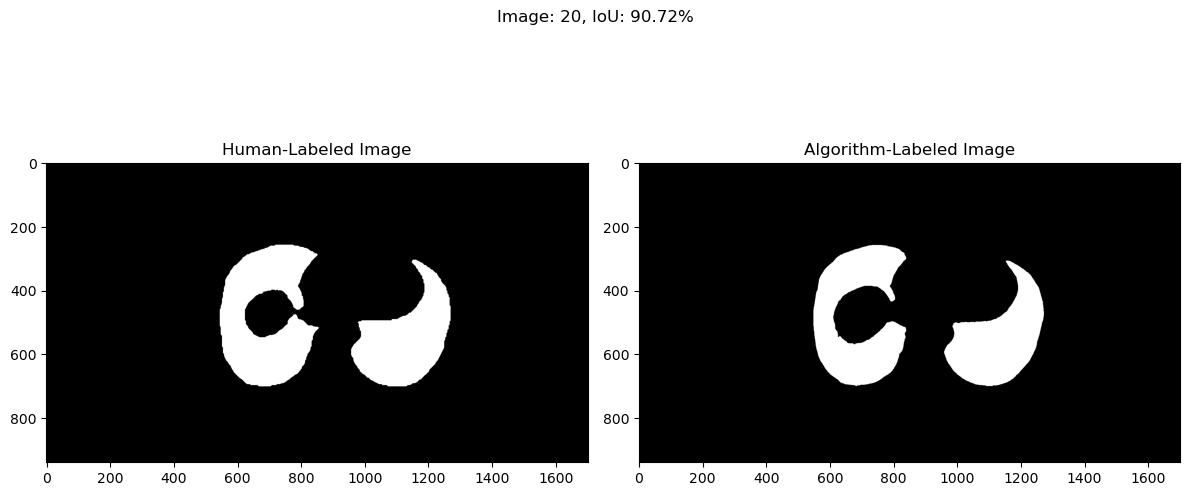

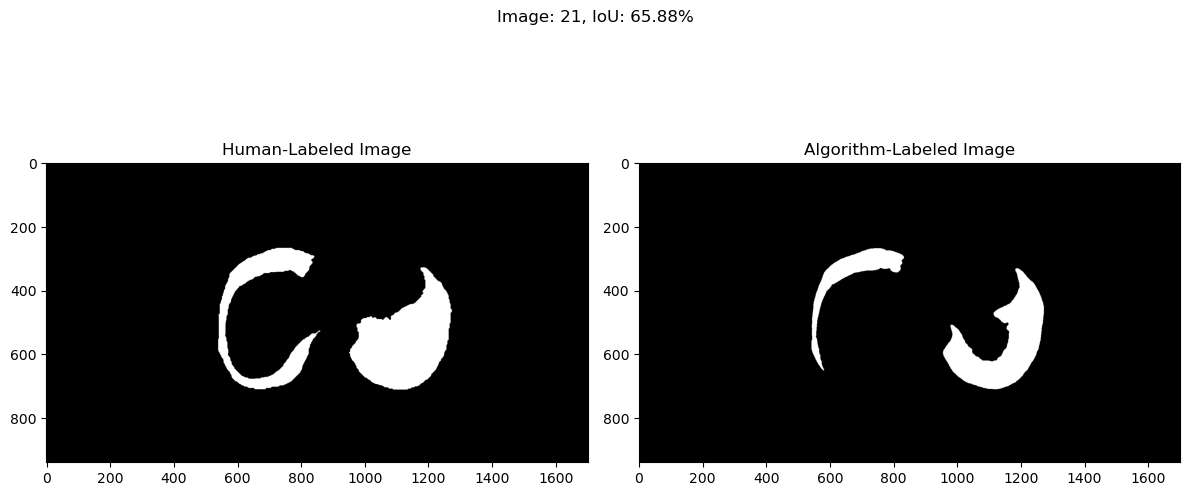

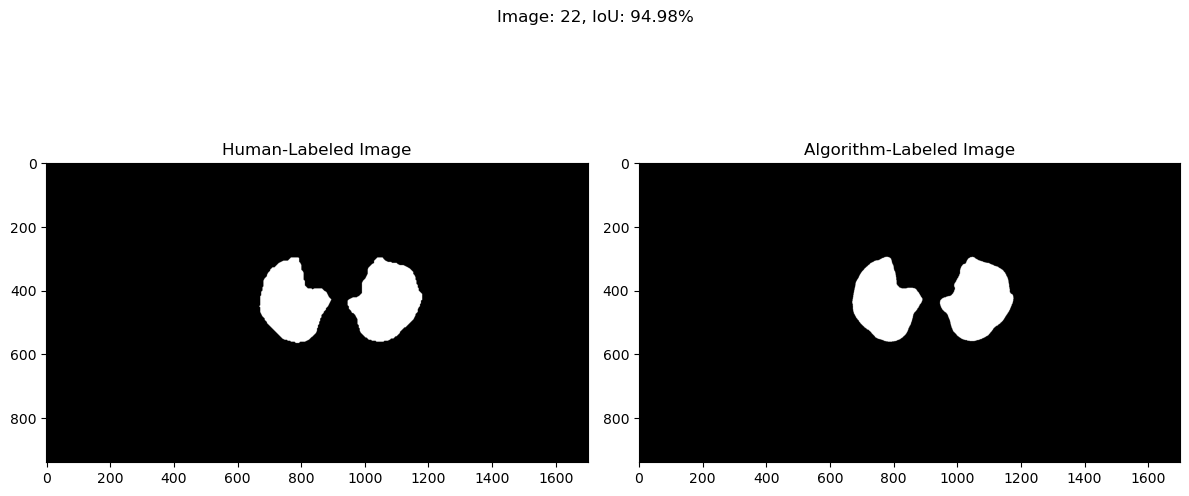

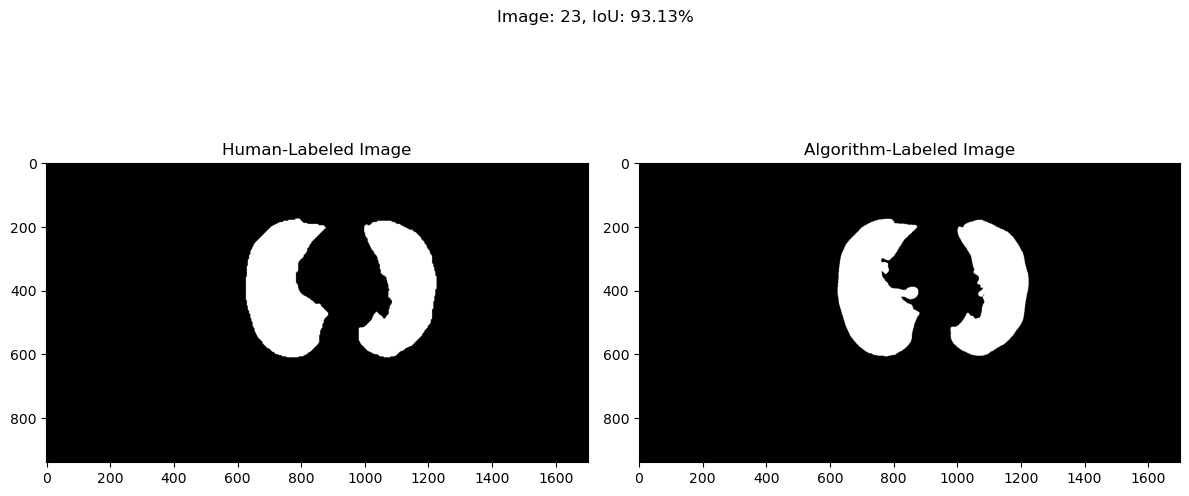

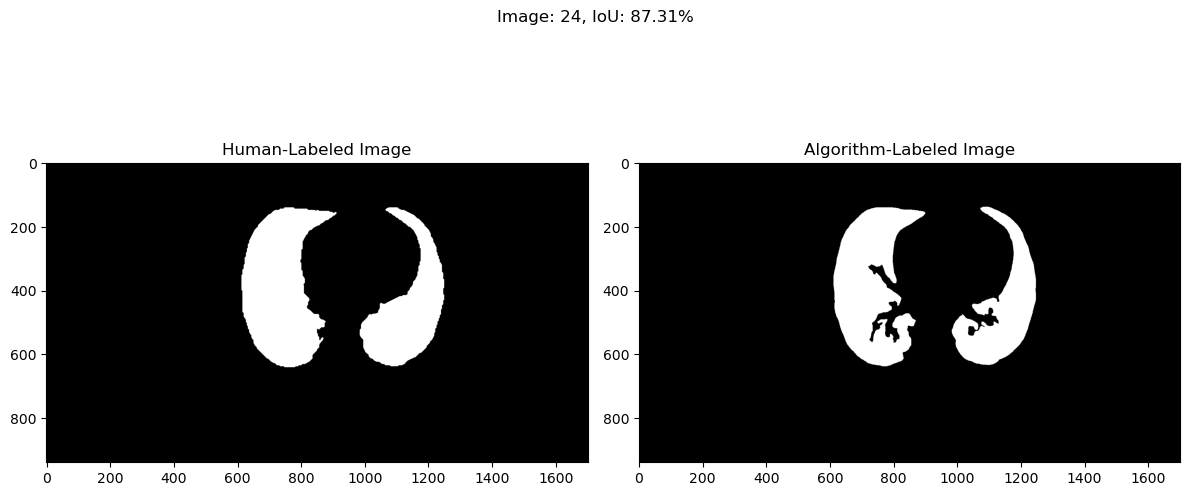

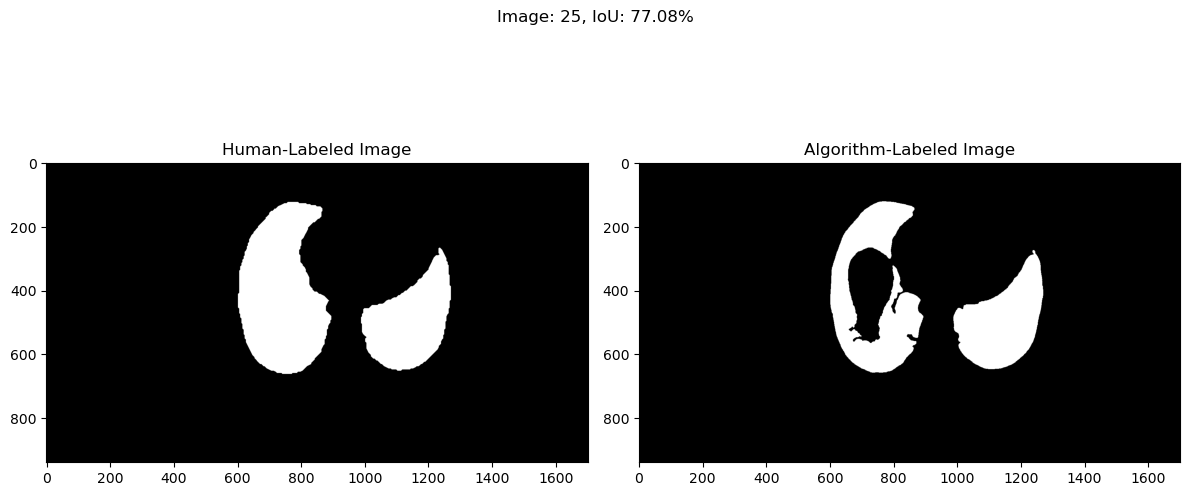

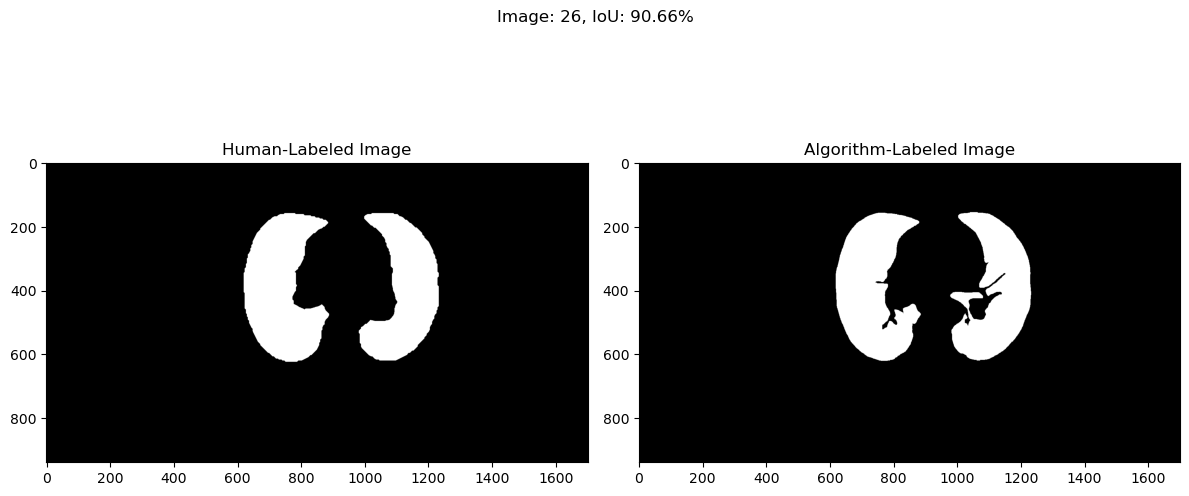

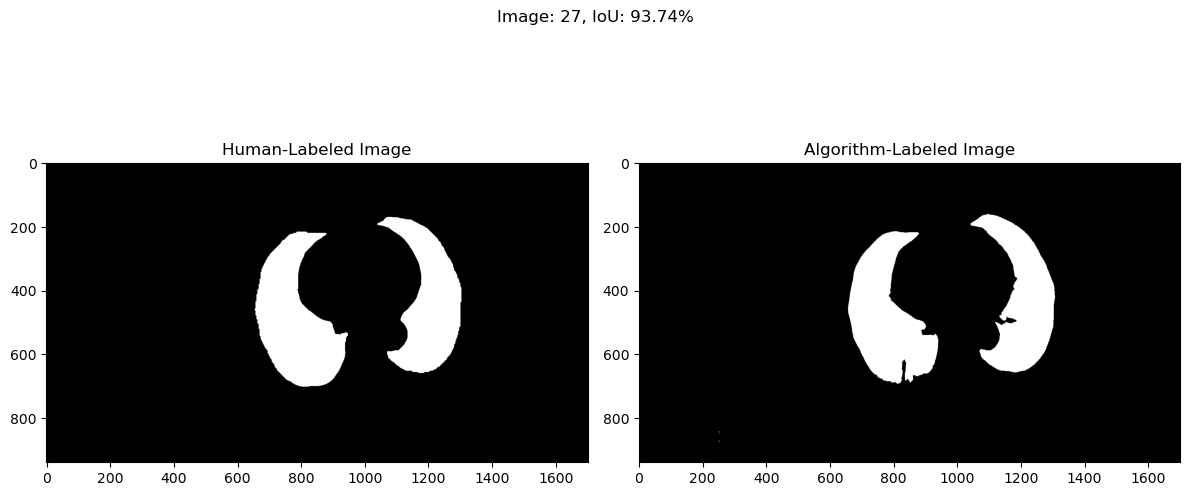

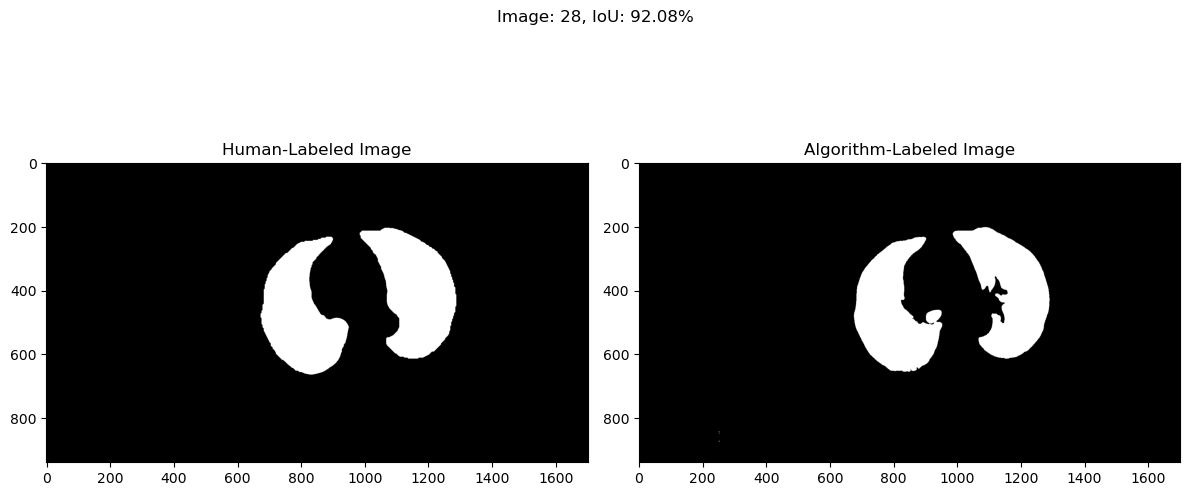

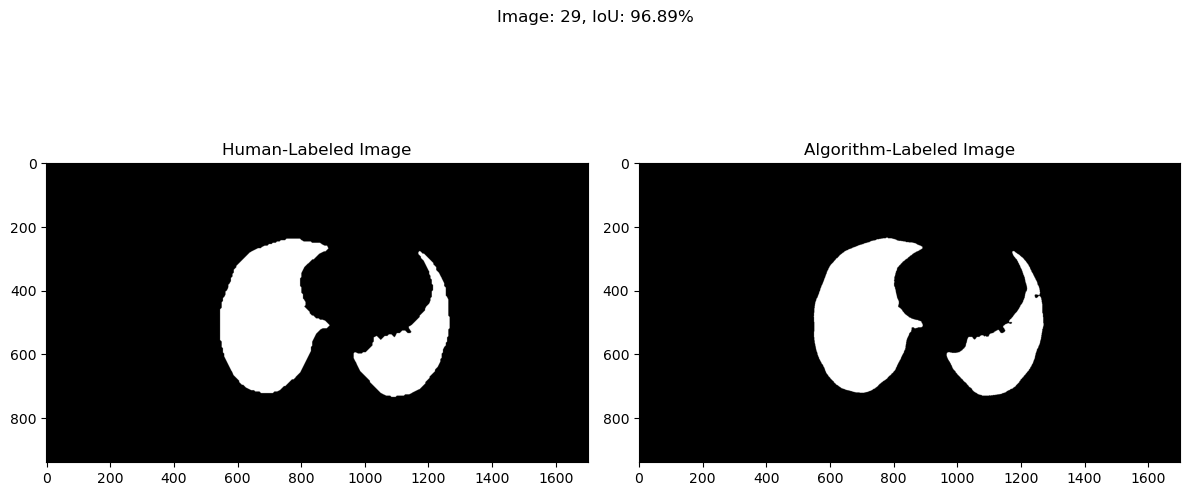

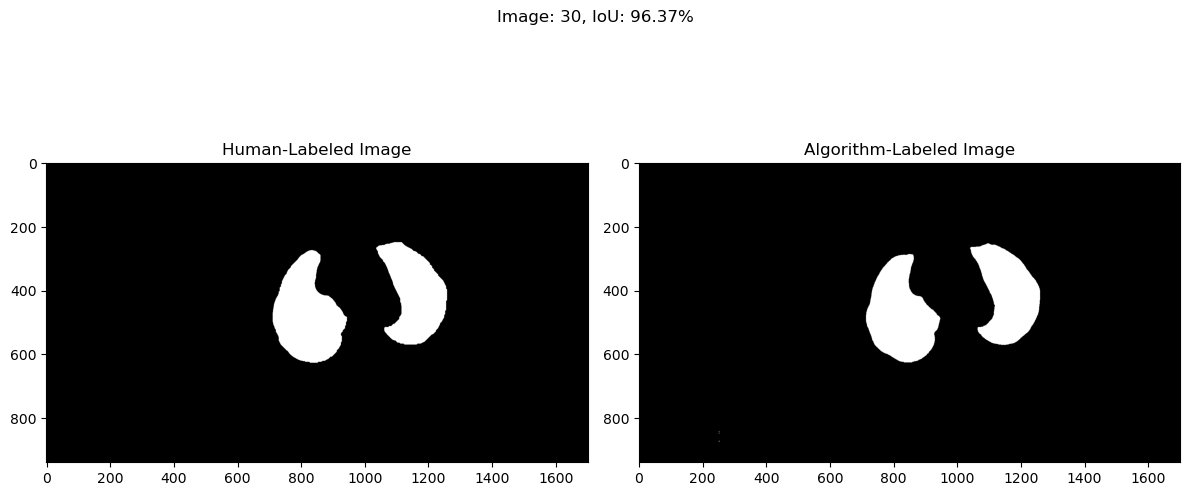

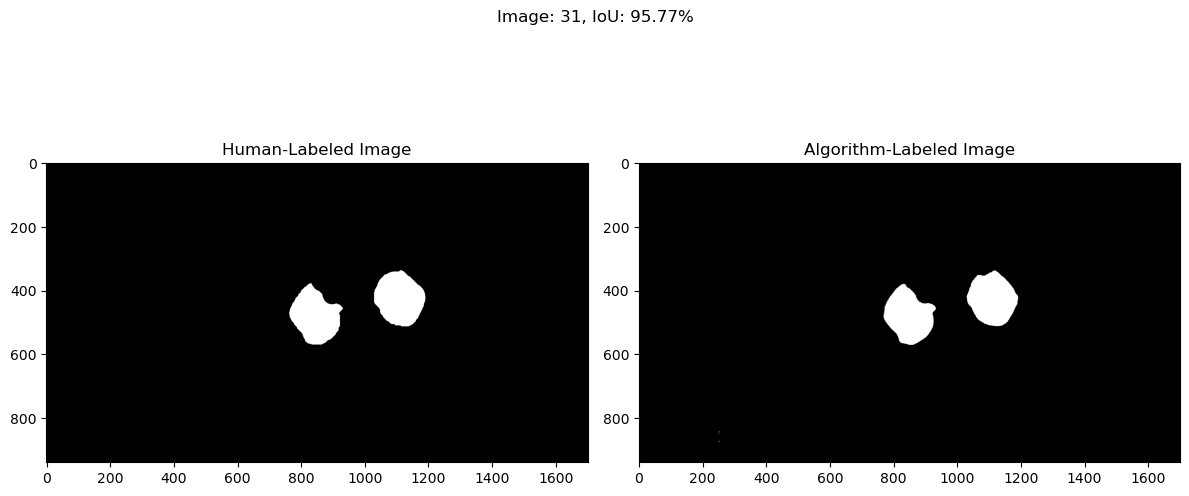

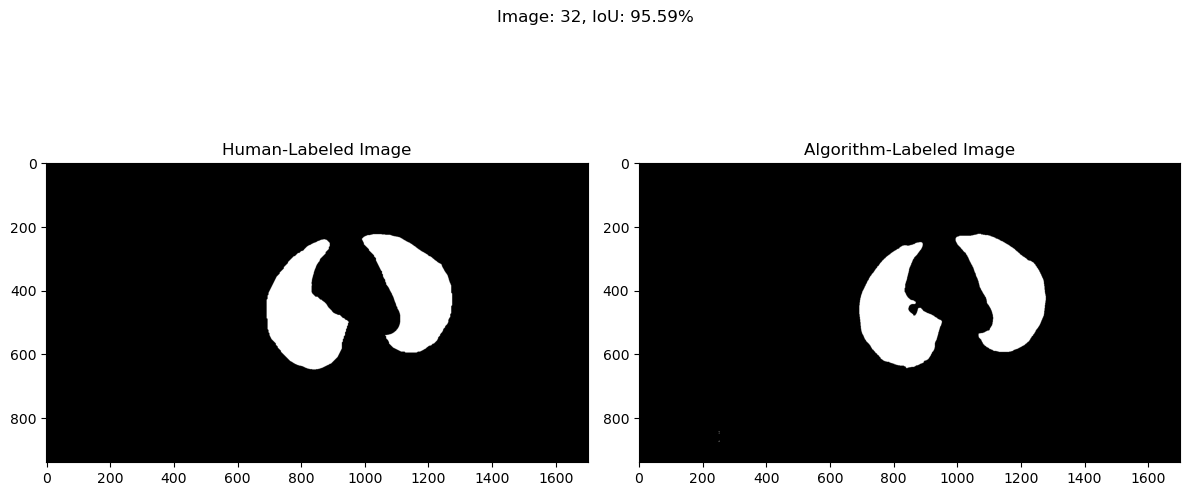

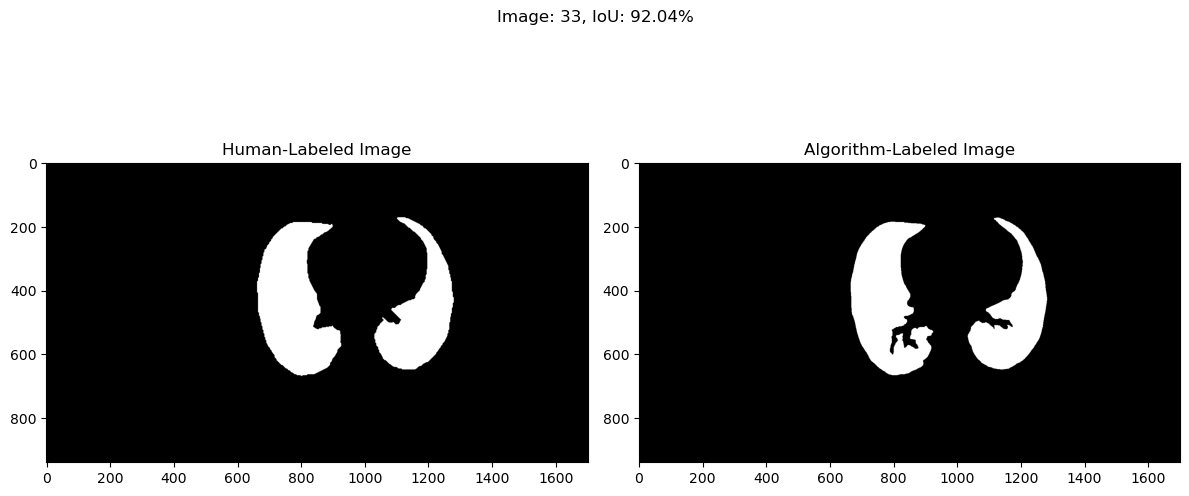

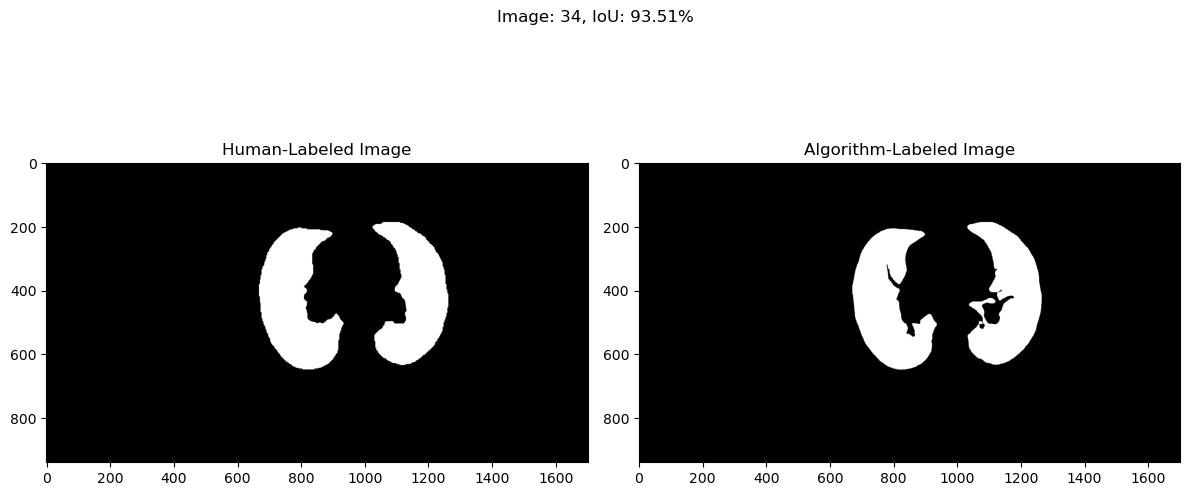

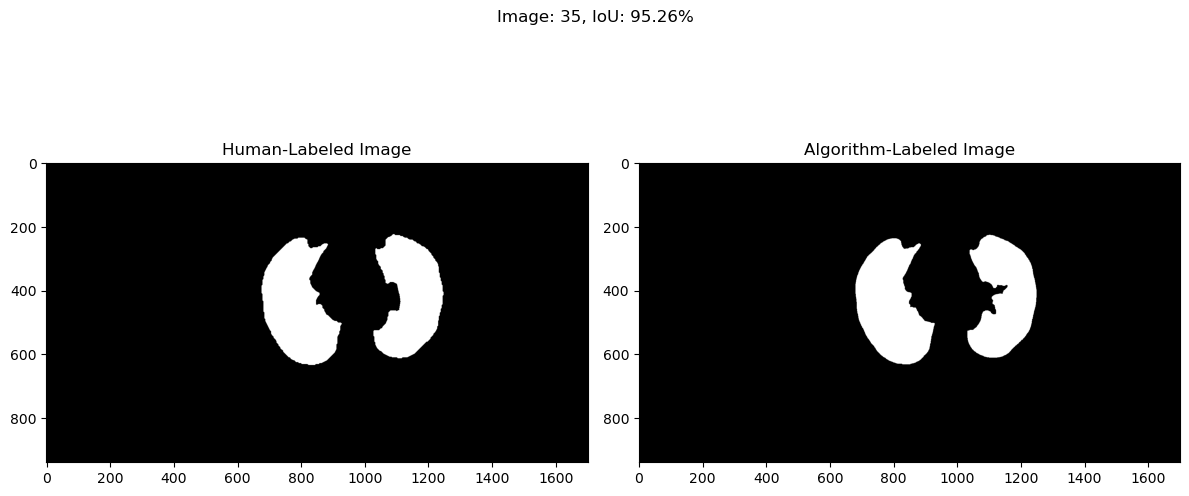

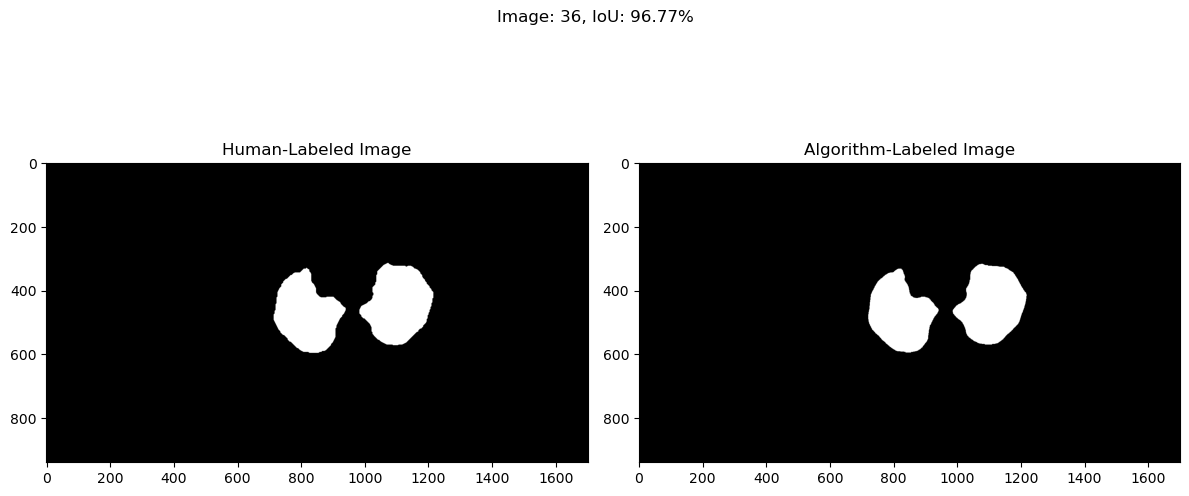

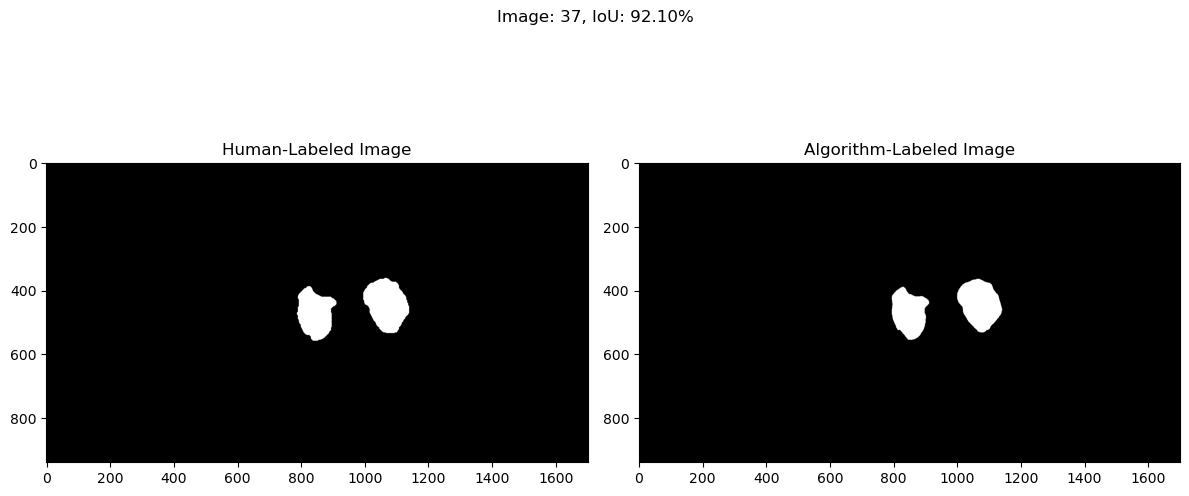

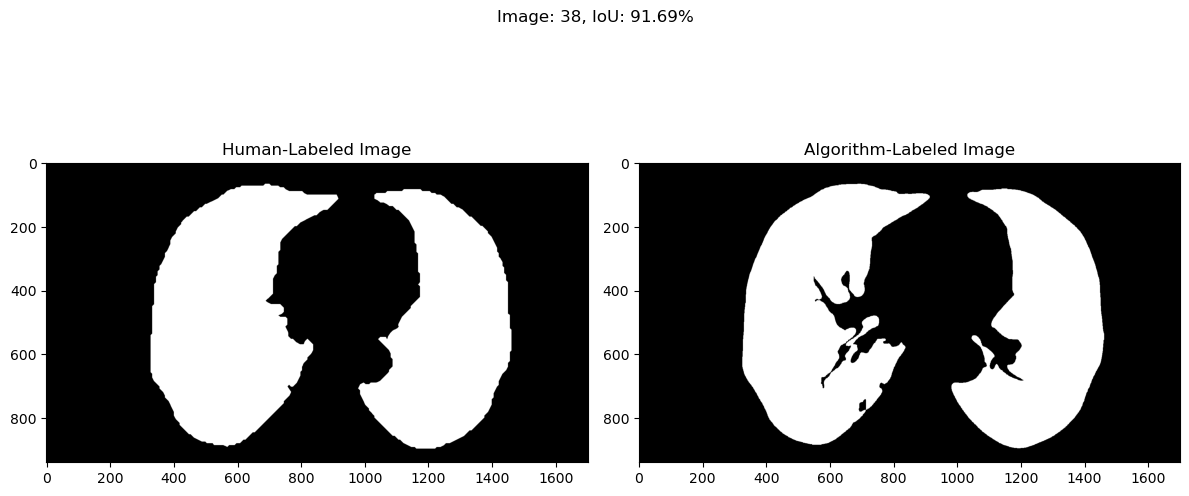

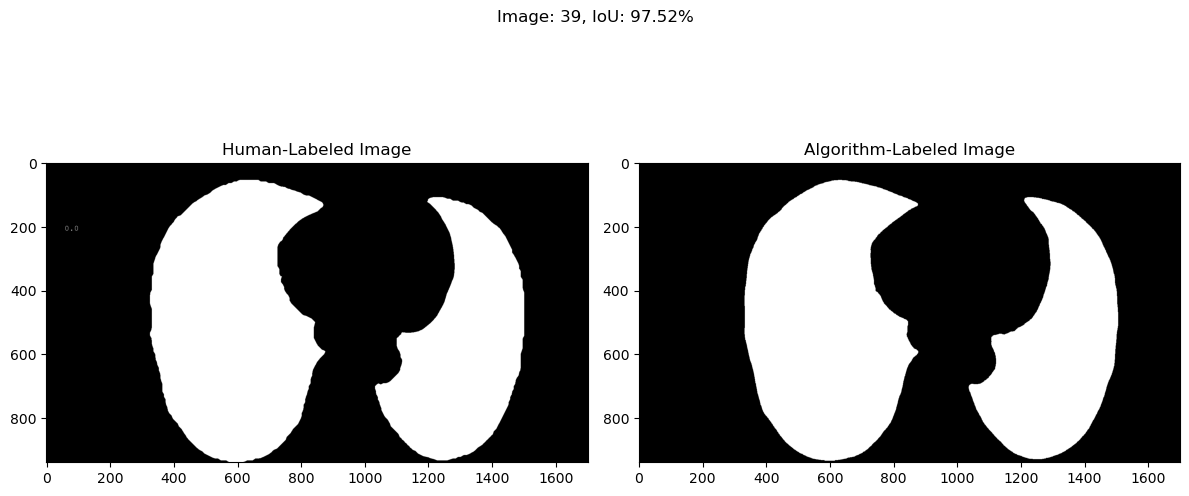

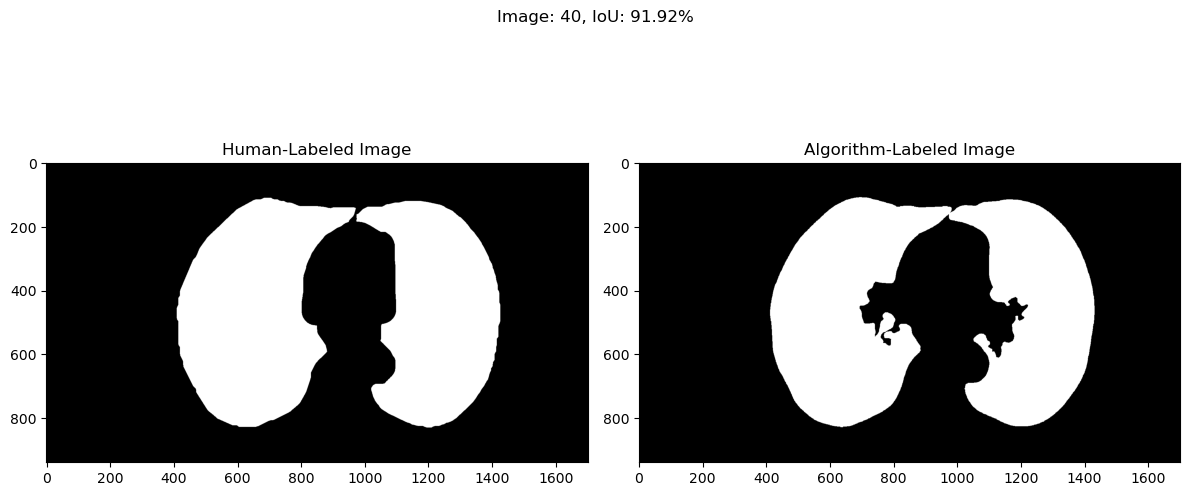

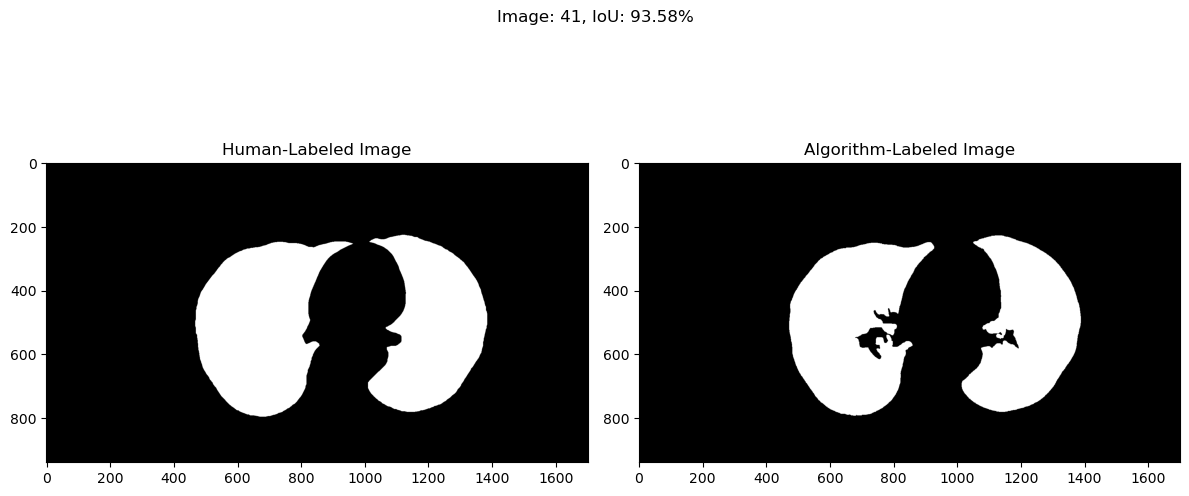

In [8]:
iou = []
for i in range(42):
    sample_iou = IoU(human_labelled_images[i], alg_labelled_images[i], i)
    iou.append(sample_iou)


# Stats

In [9]:
np.mean(iou), np.sqrt(np.var(iou))

(0.9307863198772678, 0.0550114930971143)

The segmentation algorithm shows a mean Intersection over Union (mIoU) of 93.46% with a standard deviation of 5.29% across 43 tests. 

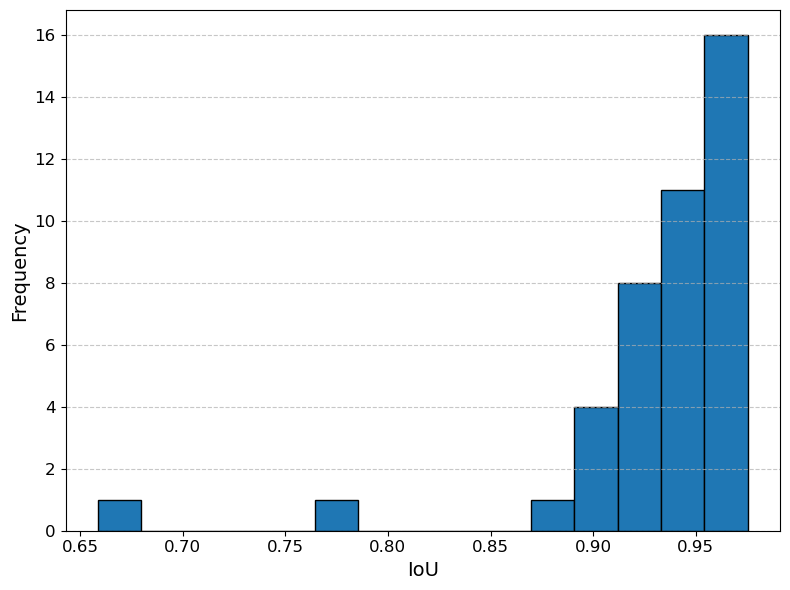

In [38]:
# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(iou, bins=15, edgecolor='black', alpha=1)

# Customize the plot
plt.xlabel('IoU', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [26]:
def dice_coeff (human_img, alg_img, label): 
    human_img_hsv = cv.cvtColor(human_img, cv.COLOR_BGR2HSV)
    lower_green = (40, 40, 40) 
    upper_green = (80, 255, 255)
    human_mask = cv.inRange(human_img_hsv, lower_green, upper_green)

    alg_img_hsv = cv.cvtColor(alg_img, cv.COLOR_BGR2HSV)
    lower_blue = (100,50,50)
    upper_blue = (140,255,255)
    alg_mask = cv.inRange(alg_img_hsv,lower_blue,upper_blue)

    intersection_size = np.count_nonzero(np.bitwise_and(human_mask, alg_mask))
    union_size = np.count_nonzero(human_mask)+np.count_nonzero(alg_mask)
    dice = 2*intersection_size/union_size
    return dice

In [27]:
dice = []
for i in range(42):
    sample_dice = dice_coeff(human_labelled_images[i], alg_labelled_images[i], i)
    dice.append(sample_dice)

In [28]:
np.mean(dice), np.sqrt(np.var(dice))

(0.9632174006933444, 0.032873536867275406)

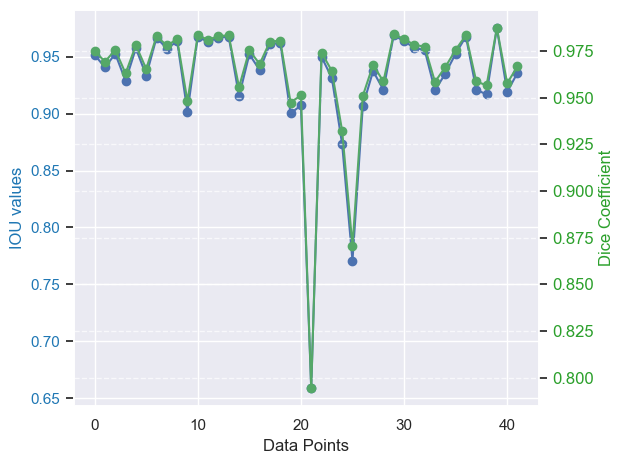

In [52]:
# Plot the scatter plot
import seaborn as sns; sns.set()

# Creating plot with dataset_1
fig, ax1 = plt.subplots() 
 
color = 'tab:blue'
ax1.set_xlabel('Data Points') 
ax1.set_ylabel('IOU values', color = color) 
ax1.plot(iou, 'b-o') 
ax1.tick_params(axis ='y', labelcolor = color) 
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx() 
 
color = 'tab:green'
ax2.set_ylabel('Dice Coefficient', color = color) 
ax2.plot(dice, 'g-o') 
ax2.tick_params(axis ='y', labelcolor = color) 
 

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
def accuracy(human_img, alg_img, label):
    human_img_hsv = cv.cvtColor(human_img, cv.COLOR_BGR2HSV)
    lower_green = (40, 40, 40) 
    upper_green = (80, 255, 255)
    human_mask = cv.inRange(human_img_hsv, lower_green, upper_green)

    alg_img_hsv = cv.cvtColor(alg_img, cv.COLOR_BGR2HSV)
    lower_blue = (100,50,50)
    upper_blue = (140,255,255)
    alg_mask = cv.inRange(alg_img_hsv,lower_blue,upper_blue)

    tp = np.count_nonzero((human_mask == 255) & (alg_mask == 255))
    tn = np.count_nonzero((human_mask == 0) & (alg_mask == 0))
    fp = np.count_nonzero((human_mask == 0) & (alg_mask == 255))
    fn = np.count_nonzero((human_mask == 255) & (alg_mask == 0))
        
    acc = (tp+tn)/(tp+tn+fp+fn)
    balanced_acc = 0.5*((tp/(tp+fn))+(tn/(tn+tp)))
    prec = tp/(tp+ fp)

    return acc,prec
    

In [16]:
acc_arr = []
prec_arr = []
for i in range(42):
    sample_acc,sample_prec = accuracy(human_labelled_images[i], alg_labelled_images[i], i)
    acc_arr.append(sample_acc)
    prec_arr.append(prec_arr)

In [17]:
np.mean(acc_arr), np.sqrt(np.var(acc_arr))

(0.9912474074736278, 0.0067816776312465835)

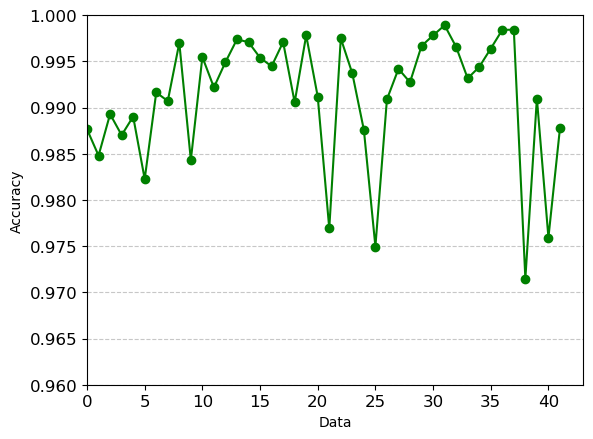

In [22]:
plt.plot(acc_arr, 'go-')
plt.xlabel('Data')
plt.ylabel('Accuracy')
plt.axis([0,43,0.96,1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [53]:
max(dice),min(dice)

(0.9874463512776034, 0.7943027566407448)

In [54]:
max(iou),min(iou)

(0.9752039830418143, 0.6587912189528583)